In [1]:
import json

# Open and read the JSON file
with open('/Users/naranja/Downloads/EXIST 2025 Dataset V0.3/EXIST 2025 Videos Dataset/training/EXIST2025_training.json', 'r') as file:
    train_data = json.load(file)
with open('/Users/naranja/Downloads/EXIST 2025 Dataset V0.3/EXIST 2025 Videos Dataset/test/EXIST2025_test_clean.json', 'r') as file:
    test_data = json.load(file)

In [2]:
import pandas as pd
import numpy as np

train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)
train_df = train_df.transpose()
test_df = test_df.transpose()

train_df = train_df[train_df['lang'] == 'en']
test_df = test_df[test_df['lang'] == 'en']

In [3]:
import re
import string
import nltk
import tensorflow as tf

nltk.download('stopwords')
from nltk.corpus import stopwords

stop = set(stopwords.words(fileids=('english')))
def remove_stopwords(text):
    filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(filtered_words)

def normalize_whitespace(text_tensor):
    # Replace tabs and newlines with space
    text_tensor = tf.strings.regex_replace(text_tensor, r"[\t\n\r]+", " ")

    # Replace multiple spaces with single space
    text_tensor = tf.strings.regex_replace(text_tensor, r"\s{2,}", " ")

    # Strip leading/trailing whitespace
    text_tensor = tf.strings.strip(text_tensor)
    return text_tensor

def remove_username(text):
    user = re.compile(r"@[^\s]+")
    return user.sub(r"", text)

def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)

def remove_punct(text):
    translator = str.maketrans("", "", string.punctuation)
    return text.translate(translator)

def remove_emails(text):
    # Define email pattern using re
    email_pattern = re.compile(
        r"\b[\w\.-]+@[\w\.-]+\.\w{2,4}\b",  # Basic email pattern
        flags=re.UNICODE
    )
    email_regex_str = email_pattern.pattern
    cleaned_text = tf.strings.regex_replace(text, email_regex_str, "")
    return cleaned_text

def remove_emoji(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        u"\U0001F680-\U0001F6FF"  # Transport & Map Symbols
        u"\U0001F1E0-\U0001F1FF"  # Flags
        u"\U00002700-\U000027BF"  # Dingbats
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U00002600-\U000026FF"  # Misc symbols
        "]+", 
        flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)

2025-05-19 11:41:22.924281: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/naranja/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
train_df['text'] = train_df['text'].apply(
    lambda x: remove_emails(tf.constant(x)).numpy().decode('utf-8')
)
train_df['text'] = train_df.text.map(remove_username)
train_df['text'] = train_df.text.map(remove_URL)
train_df['text'] = train_df.text.map(remove_punct)
train_df['text'] = train_df.text.map(remove_emoji)
train_df['text'] = train_df['text'].apply(
    lambda x: normalize_whitespace(tf.constant(x)).numpy().decode('utf-8')
)
test_df['text'] = test_df['text'].apply(
    lambda x: remove_emails(tf.constant(x)).numpy().decode('utf-8')
)
test_df['text'] = test_df.text.map(remove_username)
test_df['text'] = test_df.text.map(remove_URL)
test_df['text'] = test_df.text.map(remove_punct)
test_df['text'] = test_df.text.map(remove_emoji)
test_df['text'] = test_df['text'].apply(
    lambda x: normalize_whitespace(tf.constant(x)).numpy().decode('utf-8')
)

In [5]:
def compute_soft_and_hard_label(votes, positive_token="YES", negative_token="NO"):
    """
    Converts annotator votes into soft and hard labels.

    Args:
        votes (list of str): Annotator votes, e.g., ['NO', 'YES', 'NO', 'YES']
        positive_token (str): The string representing a positive label (default: 'YES')
        negative_token (str): The string representing a negative label (default: 'NO')

    Returns:
        soft_label (list of float): [prob_yes, prob_no]
        hard_label (int): 1 if YES wins, 0 otherwise
    """
    total = len(votes)
    yes_count = sum(1 for v in votes if v == positive_token)
    no_count = total - yes_count

    prob_yes = yes_count / total
    prob_no = no_count / total

    hard_label = 1 if prob_yes >= 0.5 else 0

    return [prob_yes, prob_no], hard_label

In [6]:
train_df['labels_task3_1_hard'] = None
train_df['labels_task3_1_soft'] = None

for index, row in train_df.iterrows():
    soft, hard = compute_soft_and_hard_label(row['labels_task3_1'])
    if hasattr(hard, '__iter__') and not isinstance(hard, (str, bytes)):
        hard = hard[0]  # Take first value or use another approach
    
    if isinstance(soft, np.ndarray):
        soft = soft.tolist()
    train_df.at[index, 'labels_task3_1_hard'] = hard
    train_df.at[index, 'labels_task3_1_soft'] = soft

In [7]:
csv_file_train = '/Users/naranja/Desktop/EXIST/task_3_1/training.csv'
csv_file_test = '/Users/naranja/Desktop/EXIST/task_3_1/test.csv'
train_df.to_csv(csv_file_train, index=False)
test_df.to_csv(csv_file_test, index=False)

In [8]:
train_text = train_df['text'].astype(str).to_numpy()
hard_labels = train_df['labels_task3_1_hard'].astype('int32').to_numpy()
train_soft_labels = np.stack(train_df['labels_task3_1_soft'].to_numpy()).astype(np.float32)

In [9]:
import keras
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

# Define vectorizer (adjust max_tokens and sequence_length as needed)
vectorizer = TextVectorization(
    max_tokens=10000,
    output_sequence_length=100,
    standardize='lower_and_strip_punctuation'
)

# Fit it on your training text
vectorizer.adapt(train_text)

In [10]:
def create_model(use_soft_labels=False):
    """
    Create a simple text classification model
    """
    inputs = keras.Input(shape=(), dtype=tf.string, name="text_input")
    x = vectorizer(inputs)  # Now outputs shape (None, 100) of int32                    
    x = layers.Embedding(input_dim=10000, output_dim=16)(x)
    x = layers.Conv1D(128, 5, activation='relu')(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    if use_soft_labels:
        outputs = tf.keras.layers.Dense(2, activation='softmax')(x)
        loss = 'categorical_crossentropy'
    else:
        outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
        loss = 'binary_crossentropy'

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
    
    return model

In [11]:
def predict_text(model, test_df, threshold=0.5, label_mode='soft'):
    """
    Predicts on test text using a trained model.

    """
    test_text = test_df['text'].astype(str).to_numpy()

    # Get raw predictions from model
    preds = model.predict(test_text)

    if len(preds.shape) > 1 and preds.shape[1] == 2:
        if label_mode == 'soft':
            test_df['soft_pred'] = preds.tolist()  # Store the entire 2D array as lists in the column
        elif label_mode == 'hard':
            test_df['hard_pred'] = np.argmax(preds, axis=1)  # 0 = NO, 1 = YES
    else:
        if label_mode == 'soft':
            # For sigmoid output, create the complementary probability
            probs = preds.flatten()  # Ensure it's 1D
            test_df['soft_pred'] = [[p, 1-p] for p in probs]  # Store as list of pairs [p, 1-p]
        elif label_mode == 'hard':
            test_df['hard_pred'] = (preds.flatten() > threshold).astype(int)
            
    return test_df

In [12]:
def save_predictions_to_csv(df, output_file='predictions.csv', threshold=0.5):
    """
    Saves meme texts and their predictions to a CSV file.
    """
    
    # Create a copy of the DataFrame to avoid modifying the original
    result_df = pd.DataFrame()
    result_df['id'] = df['id_EXIST']
    result_df['text'] = df['text']
    
    # Process soft predictions if available
    if 'soft_pred' in df.columns:
        # Check if soft_pred contains lists (for 2-class output)
        if isinstance(df['soft_pred'].iloc[0], list):
            # For 2D predictions: index 1 is the probability for YES (class 1)
            result_df['Probability_YES'] = df['soft_pred'].apply(lambda x: x[1])
        else:
            # For 1D predictions: the value is directly the probability for YES
            result_df['Probability_YES'] = df['soft_pred']
            
        # Convert probabilities to YES/NO
        result_df['Prediction'] = result_df['Probability_YES'].apply(
            lambda x: 'YES' if x > threshold else 'NO'
        )
    
    # Use hard predictions if available and soft predictions aren't
    elif 'hard_pred' in df.columns:
        result_df['Prediction'] = df['hard_pred'].apply(
            lambda x: 'YES' if x == 1 else 'NO'
        )
    
    # Save the results to CSV
    result_df.to_csv(output_file, index=False)
    print(f"Predictions saved to {output_file}")
    
    return result_df

In [13]:
model = create_model(use_soft_labels=False)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)         │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 100)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 16)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 96, 128)        │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,689 (698.00 KB)

 Trainable params: 178,689 (698.00 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.fit(train_text, hard_labels, epochs=10, verbose=2)

Epoch 1/10
32/32 - 3s - 94ms/step - accuracy: 0.5480 - loss: 0.6893
Epoch 2/10
32/32 - 1s - 16ms/step - accuracy: 0.5500 - loss: 0.6818
Epoch 3/10
32/32 - 1s - 16ms/step - accuracy: 0.6380 - loss: 0.6642
Epoch 4/10
32/32 - 0s - 15ms/step - accuracy: 0.6700 - loss: 0.6318
Epoch 5/10
32/32 - 0s - 16ms/step - accuracy: 0.7530 - loss: 0.5607
Epoch 6/10
32/32 - 1s - 18ms/step - accuracy: 0.8430 - loss: 0.4330
Epoch 7/10
32/32 - 0s - 15ms/step - accuracy: 0.9390 - loss: 0.2391
Epoch 8/10
32/32 - 1s - 22ms/step - accuracy: 0.9870 - loss: 0.0931
Epoch 9/10
32/32 - 1s - 17ms/step - accuracy: 0.9970 - loss: 0.0384
Epoch 10/10
32/32 - 1s - 16ms/step - accuracy: 1.0000 - loss: 0.0163


In [15]:
test_df = predict_text(model, test_df, label_mode='hard')
print(test_df[['text', 'hard_pred']])

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
                                                     text  hard_pred
420001  before vd after facewithhandovermouth facewith...          1
420002  editing him with this intro again because why ...          1
420003  ni taylor en lo ilustró mejor listen to your s...          1
420004  clean the previously detected text by removing...          0
420005  my antidepressant my favorite mansplain was wh...          1
...                                                   ...        ...
420366  women will put anything on their faces for som...          1
420367  good luck mayalu sending my best wishes for 46...          0
420368  los hombres solo somos vistos como negocio par...          0
420369         women today cuckoo thats sexual assault oh          1
420370  shortcake shortcake shortcake they really said...          0

[370 rows x 2 columns]


In [16]:
results = save_predictions_to_csv(test_df, output_file='/Users/naranja/Desktop/EXIST/task_3_1/tweet_hard_predictions.csv')

Predictions saved to /Users/naranja/Desktop/EXIST/task_3_1/tweet_hard_predictions.csv


In [17]:
model_soft = create_model(use_soft_labels=True)
model_soft.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)         │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 100)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 100, 16)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 96, 128)        │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,754 (698.26 KB)

 Trainable params: 178,754 (698.26 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model_soft.fit(train_text, train_soft_labels, epochs=10, verbose=2)

Epoch 1/10
32/32 - 3s - 90ms/step - accuracy: 0.5370 - loss: 0.6899
Epoch 2/10
32/32 - 0s - 14ms/step - accuracy: 0.5860 - loss: 0.6775
Epoch 3/10
32/32 - 0s - 14ms/step - accuracy: 0.6430 - loss: 0.6471
Epoch 4/10
32/32 - 0s - 14ms/step - accuracy: 0.7320 - loss: 0.5819
Epoch 5/10
32/32 - 0s - 14ms/step - accuracy: 0.8120 - loss: 0.5077
Epoch 6/10
32/32 - 0s - 14ms/step - accuracy: 0.8740 - loss: 0.3962
Epoch 7/10
32/32 - 1s - 17ms/step - accuracy: 0.9440 - loss: 0.2934
Epoch 8/10
32/32 - 1s - 18ms/step - accuracy: 0.9390 - loss: 0.2336
Epoch 9/10
32/32 - 1s - 17ms/step - accuracy: 0.9570 - loss: 0.2171
Epoch 10/10
32/32 - 1s - 24ms/step - accuracy: 0.9450 - loss: 0.2087


In [19]:
test_df = predict_text(model_soft, test_df, label_mode='soft')
print(test_df[['text', 'soft_pred']])

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
                                                     text  \
420001  before vd after facewithhandovermouth facewith...   
420002  editing him with this intro again because why ...   
420003  ni taylor en lo ilustró mejor listen to your s...   
420004  clean the previously detected text by removing...   
420005  my antidepressant my favorite mansplain was wh...   
...                                                   ...   
420366  women will put anything on their faces for som...   
420367  good luck mayalu sending my best wishes for 46...   
420368  los hombres solo somos vistos como negocio par...   
420369         women today cuckoo thats sexual assault oh   
420370  shortcake shortcake shortcake they really said...   

                                         soft_pred  
420001   [0.7609937787055969, 0.23900610208511353]  
420002   [0.32735002040863037, 0.6726500391960144]  
420003     [0.251526802778244, 0.7484732270240784]  
420004  [0.0450

In [20]:
results = save_predictions_to_csv(test_df, output_file='/Users/naranja/Desktop/EXIST/task_3_1/tweet_soft_predictions.csv')

Predictions saved to /Users/naranja/Desktop/EXIST/task_3_1/tweet_soft_predictions.csv


In [21]:
####################################################################################################################################

In [22]:
#####################################        MULTI_CLASS TEXT CLASSIFICATION          ##############################################

In [23]:
####################################################################################################################################

In [24]:
from sklearn.preprocessing import LabelEncoder

all_labels = ['-', 'DIRECT', 'JUDGEMENTAL', 'UNKNOWN']
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)
num_classes = len(all_labels)
num_classes

4

In [25]:
def get_majority_label(label_list):
    return max(set(label_list), key=label_list.count)

train_df['labels_task3_2_hard'] = train_df['labels_task3_2'].apply(get_majority_label)
train_df['hard_label_encoded'] = label_encoder.transform(train_df['labels_task3_2_hard'])

In [26]:
def get_soft_label(label_list):
    counts = np.zeros(num_classes)
    valid_labels = [label for label in label_list if label in all_labels]  # exclude 'UNKNOWN' or others
    if not valid_labels:
        return counts  # or you can return uniform distribution if preferred
    for label in valid_labels:
        idx = label_encoder.transform([label])[0]
        counts[idx] += 1
    return counts / len(valid_labels)

train_df['soft_label'] = train_df['labels_task3_2'].apply(get_soft_label)

In [27]:
import pandas as pd

def get_yes_predictions_df(csv_path):
    # Load CSV
    df = pd.read_csv(csv_path)
    filtered_df = df['id']
    # Normalize 'Prediction' column (strip spaces and lowercase)
    df['Prediction'] = df['Prediction'].astype(str).str.strip().str.lower()
    
    # Filter for rows where prediction is 'yes'
    filtered_df = df[df['Prediction'] == 'yes']
    
    # Optional: restore original case in 'Prediction' if needed
    filtered_df['Prediction'] = 'Yes'
    
    return filtered_df[['id', 'text', 'Prediction']]

In [28]:
csv_file_train = '/Users/naranja/Desktop/EXIST/task_3_2/training.csv'
csv_file_test = '/Users/naranja/Desktop/EXIST/task_3_2/test.csv'
train_df.to_csv(csv_file_train, index=False)
test_df.to_csv(csv_file_test, index=False)

In [29]:
train_text = train_df['text'].astype(str).to_numpy()
hard_labels = train_df['hard_label_encoded'].astype('int32').to_numpy()
soft_labels = np.stack(train_df['soft_label'].to_numpy()).astype(np.float32)

In [30]:
tokenizer = Tokenizer(num_words=1000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['text'])

In [31]:
yes_hard_df = get_yes_predictions_df('/Users/naranja/Desktop/EXIST/task_3_1/tweet_hard_predictions.csv')
yes_soft_df = get_yes_predictions_df('/Users/naranja/Desktop/EXIST/task_3_1/tweet_soft_predictions.csv')

/var/folders/_h/hm7x1kqd4955mvw_gq9y710r0000gn/T/ipykernel_24842/1196900292.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Prediction'] = 'Yes'
/var/folders/_h/hm7x1kqd4955mvw_gq9y710r0000gn/T/ipykernel_24842/1196900292.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Prediction'] = 'Yes'


In [32]:
train_sequences = tokenizer.texts_to_sequences(train_df['text'])
test_hard_sequences = tokenizer.texts_to_sequences(yes_hard_df['text'])
test_soft_sequences = tokenizer.texts_to_sequences(yes_soft_df['text'])

In [33]:
maxlen = max(len(seq) for seq in train_sequences)
train_padded = pad_sequences(train_sequences, padding='post', maxlen=maxlen)
test_hard_padded = pad_sequences(test_hard_sequences, padding='post', maxlen=maxlen)
test_soft_padded = pad_sequences(test_soft_sequences, padding='post', maxlen=maxlen)

In [34]:
y_train_hard = tf.keras.utils.to_categorical(train_df['hard_label_encoded'], num_classes=num_classes)
y_train_soft = np.stack(train_df['soft_label'].values)

In [35]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=1000, output_dim=16, input_length=maxlen),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [36]:
model = create_model()
print("Training model with hard label supervision...")
model.fit(train_padded, y_train_hard, epochs=20)

Training model with hard label supervision...
Epoch 1/20


/Users/naranja/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4588 - loss: 1.1707
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5650 - loss: 0.9909
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5428 - loss: 1.0137
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5744 - loss: 0.9694
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5418 - loss: 0.9979
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5592 - loss: 0.9852
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5404 - loss: 0.9992
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5638 - loss: 0.9873
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5380 - loss: 1.0116
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5733 - loss: 0.9681
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5460 - loss: 0.9841
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5823 - loss: 0.9486


In [37]:
predictions = model.predict(test_hard_padded)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [38]:
# === 9. Convert Predictions to Class Labels ===
yes_hard_df['predicted_hard_label'] = label_encoder.inverse_transform(np.argmax(predictions, axis=1))
yes_hard_df['predicted_hard_distribution'] = predictions.tolist()

# === 10. View Results ===
print(yes_hard_df[['text', 'predicted_hard_label']])

                                                  text predicted_hard_label
0    before vd after facewithhandovermouth facewith...                    -
1    editing him with this intro again because why ...                    -
2    ni taylor en lo ilustró mejor listen to your s...                    -
4    my antidepressant my favorite mansplain was wh...                    -
10   text clean the previously detected text by rem...                    -
..                                                 ...                  ...
355  redheart flexedbiceps flexedbiceps clean the p...                    -
360  women and men are both equally capable and int...                    -
361  she’s not a gold digger she’s a wife facewitht...                    -
365  women will put anything on their faces for som...                    -
368         women today cuckoo thats sexual assault oh                    -

[145 rows x 2 columns]


In [39]:
model = create_model()
print("Training model with soft label supervision...")
model.fit(train_padded, y_train_soft, epochs=20)

Training model with soft label supervision...
Epoch 1/20


/Users/naranja/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4953 - loss: 1.2047
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5601 - loss: 1.0551
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5475 - loss: 1.0613
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5645 - loss: 1.0489
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5786 - loss: 1.0374
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5456 - loss: 1.0473
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5720 - loss: 1.0516
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5594 - loss: 1.0445
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5801 - loss: 1.0338
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5818 - loss: 1.0257
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5740 - loss: 1.0341
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5750 - loss: 1.0229


In [40]:
predictions = model.predict(test_soft_padded)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [41]:
# === 9. Convert Predictions to Class Labels ===
yes_soft_df['predicted_soft_label'] = label_encoder.inverse_transform(np.argmax(predictions, axis=1))
yes_soft_df['predicted_soft_distribution'] = predictions.tolist()

# === 10. View Results ===
print(yes_soft_df[['text', 'predicted_soft_label']])

                                                  text predicted_soft_label
1    editing him with this intro again because why ...                    -
2    ni taylor en lo ilustró mejor listen to your s...                    -
3    clean the previously detected text by removing...                    -
4    my antidepressant my favorite mansplain was wh...          JUDGEMENTAL
5    after he told me how people used to treat him ...                    -
..                                                 ...                  ...
362  my husband left me after i was injured he said...                    -
364  when arguing with a woman okay listen yo im li...                    -
366  good luck mayalu sending my best wishes for 46...                    -
367  los hombres solo somos vistos como negocio par...                    -
369  shortcake shortcake shortcake they really said...                    -

[252 rows x 2 columns]


In [42]:
csv_file_train = '/Users/naranja/Desktop/EXIST/task_3_2/YES_hard_test.csv'
yes_hard_df.to_csv(csv_file_train, index=False)
csv_file_train = '/Users/naranja/Desktop/EXIST/task_3_2/YES_soft_test.csv'
yes_soft_df.to_csv(csv_file_train, index=False)

In [43]:
####################################################################################################################################

In [44]:
#####################################        MULTI_LABEL TEXT CLASSIFICATION          ##############################################

In [45]:
####################################################################################################################################

In [46]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import ast

In [47]:
# Constants
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 200
EPOCHS = 10

In [48]:
# Define valid labels (note: "UNKNOWN" is excluded from prediction targets)
VALID_LABELS = ['IDEOLOGICAL-INEQUALITY', 'STEREOTYPING-DOMINANCE', 'OBJECTIFICATION', 
                'SEXUAL-VIOLENCE', 'MISOGYNY-NON-SEXUAL-VIOLENCE', '-']

In [49]:
def load_data(train_file, test_file=None):
    """Load data from CSV files"""
    train_df = pd.read_csv(train_file)
    
    if test_file:
        test_df = pd.read_csv(test_file)
        return train_df, test_df
    return train_df, None

In [50]:
def preprocess_labels(labels_series):
    """
    Process labels from multiple annotators (up to 6 per tweet)
    - "-" is assigned to non-sexist instances
    - "UNKNOWN" means no label provided (should be excluded from predictions)
    """
    # Initialize multi-hot encoded matrix
    multi_hot = np.zeros((len(labels_series), len(VALID_LABELS)))
    soft_labels = np.zeros((len(labels_series), len(VALID_LABELS)))
    
    for i, label_data in enumerate(labels_series):
        try:
            # Parse the label data to get list of annotations
            annotations = []
            
            if isinstance(label_data, str):
                # Try to parse as list (handles various string formats)
                try:
                    parsed_data = ast.literal_eval(label_data)
                    if isinstance(parsed_data, list):
                        # Handle nested lists (annotators)
                        for item in parsed_data:
                            if isinstance(item, list):
                                annotations.extend([label for label in item if label != "UNKNOWN"])
                            elif item != "UNKNOWN":
                                annotations.append(item)
                    elif parsed_data != "UNKNOWN":
                        annotations.append(parsed_data)
                except:
                    # Fallback if parsing fails
                    if label_data != "UNKNOWN":
                        annotations = [label_data]
            elif not pd.isna(label_data) and label_data != "UNKNOWN":
                annotations = [str(label_data)]
            
            # Count valid label occurrences (exclude "UNKNOWN")
            label_counts = {}
            for label in annotations:
                if label in VALID_LABELS:
                    label_counts[label] = label_counts.get(label, 0) + 1
            
            # Calculate soft labels (proportions) and set hard labels
            if label_counts:
                total_valid_annotations = sum(label_counts.values())
                for label, count in label_counts.items():
                    label_idx = VALID_LABELS.index(label)
                    soft_labels[i, label_idx] = count / total_valid_annotations
                    multi_hot[i, label_idx] = 1  # Hard label (binary)
        
        except Exception as e:
            print(f"Error processing label at index {i}: {e}")
            print(f"Label data: {label_data}")
            
    return multi_hot, soft_labels

In [51]:
def prepare_text_data(train_texts, test_texts=None):
    """Tokenize and pad text data"""
    tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
    tokenizer.fit_on_texts(train_texts)
    
    # Process training data
    train_sequences = tokenizer.texts_to_sequences(train_texts)
    train_padded = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
    
    # Process test data if provided
    if test_texts is not None:
        test_sequences = tokenizer.texts_to_sequences(test_texts)
        test_padded = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
        return train_padded, test_padded, tokenizer
    
    return train_padded, None, tokenizer

In [52]:
def build_model(vocab_size, num_labels):
    """Build a Bi-LSTM model for multi-label classification"""
    # Input layer
    input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
    
    # Embedding layer
    embedding_layer = Embedding(input_dim=vocab_size, 
                                output_dim=EMBEDDING_DIM, 
                                input_length=MAX_SEQUENCE_LENGTH)(input_layer)
    
    # Bi-LSTM layers
    lstm_layer = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer)
    lstm_layer = Bidirectional(LSTM(64))(lstm_layer)
    
    # Dense layers with dropout
    dense_layer = Dense(128, activation='relu')(lstm_layer)
    dropout_layer = Dropout(0.5)(dense_layer)
    
    # Output layer with sigmoid for multi-label classification
    output_layer = Dense(num_labels, activation='sigmoid')(dropout_layer)
    
    # Create model
    model = Model(inputs=input_layer, outputs=output_layer)
    
    # Compile model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

In [53]:
def plot_training_history(history):
    """Plot training history"""
    plt.figure(figsize=(12, 5))
    
    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper left')
    
    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

In [54]:
def predict_labels(model, X, tokenizer=None, texts=None):
    """Make predictions on input data"""
    if tokenizer is not None and texts is not None:
        # Process text inputs
        sequences = tokenizer.texts_to_sequences(texts)
        X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
    
    # Predict probabilities
    y_pred_proba = model.predict(X)
    
    # Convert to binary predictions with threshold 0.5
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # Ensure at least one label is predicted (choose max probability if no labels above threshold)
    for i in range(len(y_pred)):
        if np.sum(y_pred[i]) == 0:
            max_idx = np.argmax(y_pred_proba[i])
            y_pred[i, max_idx] = 1
    
    return y_pred, y_pred_proba

In [55]:
def save_predictions(test_df, y_pred, y_pred_proba, output_file="predictions.csv"):
    """Save predictions to a CSV file"""
    # Create a copy of the test dataframe
    results_df = test_df.copy()
    
    # Add predicted hard labels (excluding "UNKNOWN" which should never be predicted)
    predicted_labels = []
    for i, pred in enumerate(y_pred):  # Added index i to the loop variable
        row_labels = [VALID_LABELS[j] for j in range(len(VALID_LABELS)) if pred[j] == 1]
        # If only "-" is predicted and there's a sexist label with probability close to the threshold, include it
        if row_labels == ["-"] and np.max(y_pred_proba[i, :-1]) > 0.3:  # assuming "-" is the last label
            next_best_idx = np.argmax(y_pred_proba[i, :-1])
            row_labels.append(VALID_LABELS[next_best_idx])
            
        predicted_labels.append(','.join(row_labels))
    
    results_df['predicted_labels'] = predicted_labels
    
    # Add probabilities for each label
    for i, label in enumerate(VALID_LABELS):
        results_df[f'prob_{label}'] = y_pred_proba[:, i]
    
    # Save to CSV
    results_df.to_csv(output_file, index=False)
    print(f"Predictions saved to {output_file}")
    
    return results_df

Loading data...
Processing labels...
Using hard labels for training

Label distribution in training data:
IDEOLOGICAL-INEQUALITY: 263.0 instances (26.30%)
STEREOTYPING-DOMINANCE: 463.0 instances (46.30%)
OBJECTIFICATION: 199.0 instances (19.90%)
SEXUAL-VIOLENCE: 61.0 instances (6.10%)
MISOGYNY-NON-SEXUAL-VIOLENCE: 79.0 instances (7.90%)
-: 643.0 instances (64.30%)
Preparing text data...
Building model...


/Users/naranja/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 100, 200)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 256)       │       336,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,518,534 (9.61 MB)

 Trainable params: 2,518,534 (9.61 MB)

 Non-trainable params: 0 (0.00 B)

Training model...
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 567ms/step - accuracy: 0.3770 - loss: 0.5981
Epoch 2/10


/Users/naranja/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/Users/naranja/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 551ms/step - accuracy: 0.4041 - loss: 0.4901
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 577ms/step - accuracy: 0.4407 - loss: 0.4481
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 610ms/step - accuracy: 0.5042 - loss: 0.3775
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 587ms/step - accuracy: 0.5510 - loss: 0.3290
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 566ms/step - accuracy: 0.5510 - loss: 0.2782
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 547ms/step - accuracy: 0.6066 - loss: 0.2403
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 569ms/step - accuracy: 0.5853 - loss: 0.2148
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 564ms/step - accuracy: 0.6336 - loss: 0.1994
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 544ms/step - accuracy: 0.6196 - loss: 0.1856


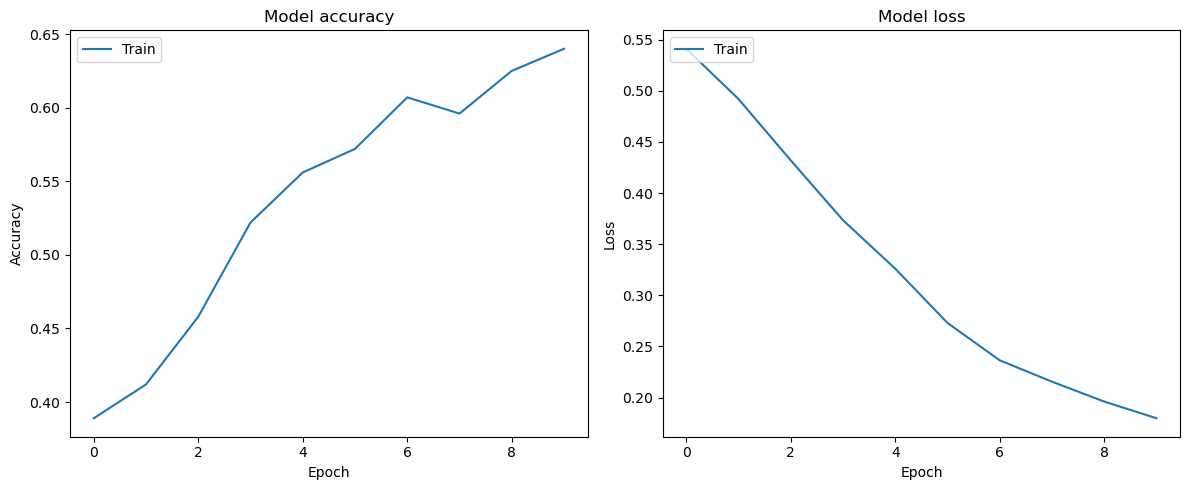

Making predictions on test data...
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 428ms/step
Predictions saved to /Users/naranja/Desktop/EXIST/task_3_3/YES_hard_test.csv


In [56]:
def main(train_file, test_file=None, use_soft_labels=True):
    # Load training and test data
    print("Loading data...")
    train_df, test_df = load_data(train_file, test_file)
         
    # Process labels
    print("Processing labels...")
    train_hard_labels, train_soft_labels = preprocess_labels(train_df['labels_task3_3'])
    
    # Use soft or hard labels based on parameter
    train_labels = train_soft_labels if use_soft_labels else train_hard_labels
    label_type = "soft" if use_soft_labels else "hard"
    print(f"Using {label_type} labels for training")
    
    # Print label distribution
    print("\nLabel distribution in training data:")
    for i, label in enumerate(VALID_LABELS):
        count = np.sum(train_hard_labels[:, i])
        print(f"{label}: {count} instances ({count/len(train_df)*100:.2f}%)")
    
    # Prepare text data
    print("Preparing text data...")
    if test_df is not None:
        X_train, X_test, tokenizer = prepare_text_data(train_df['text'], yes_hard_df['text'])
    else:
        X_train, _, tokenizer = prepare_text_data(train_df['text'])
        X_test = None
    
    # Build model
    print("Building model...")
    vocab_size = min(MAX_VOCAB_SIZE, len(tokenizer.word_index) + 1)
    model = build_model(vocab_size, len(VALID_LABELS))
    model.summary()
    
    # Train model
    print("Training model...")
    history = model.fit(
        X_train, train_labels,
        epochs=EPOCHS,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
            tf.keras.callbacks.ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True)
        ]
    )
    
    # Plot training history
    plot_training_history(history)
    
    # Make predictions on test data if available
    if test_df is not None and X_test is not None:
        print("Making predictions on test data...")
        y_pred, y_pred_proba = predict_labels(model, X_test)
        
        # Save predictions
        results_df = save_predictions(yes_hard_df, y_pred, y_pred_proba, '/Users/naranja/Desktop/EXIST/task_3_3/YES_hard_test.csv') 
        
if __name__ == "__main__":
    main("/Users/naranja/Desktop/EXIST/task_3_1/training.csv", "/Users/naranja/Desktop/EXIST/task_3_2/YES_hard_test.csv", use_soft_labels=False)